# Import Relevant Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
import seaborn as sns
import os

# Obtain and Preprocess Transient Data

In [2]:
t_data = pd.read_csv("All_Transient_Data.csv")

In [3]:
# Feature columns that are relevant for training
feature_cols = ['chi_square', 'chi_square_sigma', 'peak_map', 'peak_map_sigma','md_deep', 'deep_sep_arcsec', 
                'deep_num', 'bright_sep_arcmin', 'beam_sep_deg', 'deep_peak_flux', 'deep_int_flux','std_map']

In [4]:
t_data.head()

,source_id,name,ra_str,dec_str,ra,dec,chi_square,chi_square_log_sigma,chi_square_sigma,peak_map,...,beam,sbid,PSR_name,PSR_sep,dyspec,KNOWN_name,KNOWN_sep,PSR_name_int,KNOWN_name_int,PSR_Label
0,0,J163259.92-501507.22,16:32:59.92,-50:15:07.22,248.249681,-50.252004,2.874275,6.047280,7.511542,4.286386,...,beam00,49588,J1633-5015,1.934309,NaN,NaN,NaN,1,0,1
1,1,J163048.20-491129.49,16:30:48.20,-49:11:29.49,247.700817,-49.191524,2.465644,5.211199,6.240665,3.523429,...,beam00,49588,NaN,NaN,NaN,NaN,NaN,0,0,0
2,0,J162710.82-481537.04,16:27:10.82,-48:15:37.04,246.795077,-48.260289,3.333277,6.090706,8.813457,3.578227,...,beam04,49588,NaN,NaN,NaN,NaN,NaN,0,0,0
3,0,J163250.42-482506.53,16:32:50.42,-48:25:06.53,248.210091,-48.418480,3.578913,5.044124,9.465821,4.424191,...,beam05,49588,NaN,NaN,NaN,NaN,NaN,0,0,0
4,0,J164019.07-490047.32,16:40:19.07,-49:00:47.32,250.079454,-49.013143,3.547815,5.492090,9.384754,4.350268,...,beam06,49588,NaN,NaN,NaN,NaN,NaN,0,0,0


## Substitute Infinite Values and Remove Null Values

In [5]:
def check_val_exists(val, data):
    """
    Determines if a value exists in the dataset. If the value does exist,
    the column which contains it is displayed.
    
    Parameters
    ----------
    val : float
        Value of interest

    data : pandas dataframe
        The dataframe that is being checked.
    """
    cols = data.columns
    rel_cols = []
    for c in cols:
        val_exists = sum(data[c].unique() == val) 
        if val_exists:
            rel_cols.append(c)
            print(c ,"contains", val)

In [6]:
check_val_exists(np.inf, t_data)

chi_square_sigma contains inf
peak_map_sigma contains inf


In [7]:
# Following code is used to figure out what value to substitute infinite for.

# Since the max values for "chi_square_sigma" and "peak_map_sigma" are 21 and 37, using 1E6 should be sufficient to be
# considered infinite relative to these two particular columns.
idx_css = t_data[t_data["chi_square_sigma"] == np.inf].index
t_data = t_data.drop(idx_css)
print(t_data["chi_square_sigma"].max()) # 37.73066936470456
print(t_data["peak_map_sigma"].max()) # 21.843528800716854

37.73066936470456
21.843528800716854


In [8]:
def process_data(filename, feature_cols):
    """
    Replaces infinite values with 1,000,000 and replaces NaN values with the column's median.
    This is only done for particular columns of interest.

    Parameters
    ----------
    filename : str
        Path to the file with data we want to process.

    feature_cols : list
        List of strings og features or columns in the data that we want to process.

    Returns
    -------
    df : pandas dataframe
        The processed dataframe.
    """
    df = pd.read_csv(filename)

    # Replace inf values with large floats so the classifier can use the value
    # Choice of 1E6 because it is much larger than the maximum values of columns with inf as a value.
    df[feature_cols] = df[feature_cols].replace(np.inf, float(1E6))

    # Replace NaN values with the median
    df[feature_cols] = df[feature_cols].fillna(df[feature_cols].median())
    return df

In [9]:
t_data = process_data("All_Transient_Data.csv", feature_cols)

In [10]:
# Check for null values
t_data[feature_cols].isnull().any()

chi_square           False
chi_square_sigma     False
peak_map             False
peak_map_sigma       False
md_deep              False
deep_sep_arcsec      False
deep_num             False
bright_sep_arcmin    False
beam_sep_deg         False
deep_peak_flux       False
deep_int_flux        False
std_map              False
dtype: bool

# Balance The Data

In [11]:
# For reproducibility, you can set random_state to a particular value such as 43
random_state = None

# Number of non transients has to be the same as the number of transients
num_rand_vals = sum(t_data["PSR_Label"]==1)

# Randomly obtain the same number of non transients
false_t_data = t_data[t_data["PSR_Label"] == 0]
reduced_false_t_data = false_t_data.sample(n=num_rand_vals, random_state = random_state, axis = 0)
balanced_t_data = pd.concat([reduced_false_t_data, t_data[t_data["PSR_Label"]==1]], ignore_index=True, axis = 0)
# shuffle all the data
balanced_t_data = balanced_t_data.sample(frac=1, random_state = random_state, axis=0)

In [12]:
balanced_t_data["PSR_Label"].value_counts()

PSR_Label
0    589
1    589
Name: count, dtype: int64

In [13]:
balanced_t_data.head()

,source_id,name,ra_str,dec_str,ra,dec,chi_square,chi_square_log_sigma,chi_square_sigma,peak_map,...,beam,sbid,PSR_name,PSR_sep,dyspec,KNOWN_name,KNOWN_sep,PSR_name_int,KNOWN_name_int,PSR_Label
269,7,J044437.62-575342.22,04:44:37.62,-57:53:42.22,71.156742,-57.895060,26.747440,7.172037,28.483253,11.975624,...,beam32,50230,NaN,NaN,NaN,NaN,NaN,0,0,0
689,0,J082015.41-411435.09,08:20:15.41,-41:14:35.09,125.064203,-41.243081,51.790974,22.900391,1000000.000000,12.378450,...,beam18,49891,J0820-4114,0.589679,NaN,NaN,NaN,1,0,1
970,0,J164449.15-455909.68,16:44:49.15,-45:59:09.68,251.204784,-45.986021,516.824341,29.701546,1000000.000000,32.986904,...,beam28,61302,J1644-4559,1.301809,http://localhost:8053/dyspec/SB61302_J164449.1...,NaN,NaN,1,0,1
320,1,J043329.77-590033.20,04:33:29.77,-59:00:33.20,68.374061,-59.009222,63.894882,8.022120,1000000.000000,13.596757,...,beam30,50230,NaN,NaN,NaN,NaN,NaN,0,0,0
1126,0,J164449.22-455908.52,16:44:49.22,-45:59:08.52,251.205084,-45.985699,302.749146,21.644117,1000000.000000,23.470316,...,beam12,62788,J1644-4559,1.313331,NaN,NaN,NaN,1,0,1


# Training The Decision Tree Classifier

Decision trees classify input data by setting different conditional thresholds for the input features it deems are the most important.

__For more information on decision and including their pros and cons, it would be useful to look at:__
https://scikit-learn.org/1.5/modules/tree.html

In [14]:
# Determine the most important features
def feature_accuracies(feature_cols, balanced_t_data):
    """
    For each feature of interest, we see how accurately a decision tree classifier
    can use the feature to classify test data, after being trained on a balanced dataframe.

    Parameters
    ----------
    feature_cols : list
        List of strings of features of interest.

    balanced_t_data : pandas dataframe
        A balanced data frame which means that the number of each label is approximately the same.

    Returns
    -------
    acc_dict : dict
        A dictionary with each feature mapped to its accuracy.
    """
    acc_dict = {}
    for feature in feature_cols:
        # Input Data
        X = balanced_t_data[[feature]]
        
        # Labels
        y = balanced_t_data["PSR_Label"]
        
        # Split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = random_state)
        
        # Create Decision Tree classifer object
        model = DecisionTreeClassifier()
        
        # Train Decision Tree Classifer
        model = model.fit(X_train,y_train)
        
        #Predict the response for test dataset
        y_pred = model.predict(X_test)
        
        print(f"Accuracy for {feature}:",metrics.accuracy_score(y_test, y_pred))
    
        acc_dict[feature] = metrics.accuracy_score(y_test, y_pred)
        acc_dict = dict(sorted(acc_dict.items(),reverse = True, key=lambda item: item[1]))
        
    return acc_dict

In [15]:
acc_dict = feature_accuracies(feature_cols, balanced_t_data)

Accuracy for chi_square: 0.5169491525423728
Accuracy for chi_square_sigma: 0.5056497175141242
Accuracy for peak_map: 0.5621468926553672
Accuracy for peak_map_sigma: 0.5621468926553672
Accuracy for md_deep: 0.672316384180791
Accuracy for deep_sep_arcsec: 0.9717514124293786
Accuracy for deep_num: 0.6694915254237288
Accuracy for bright_sep_arcmin: 0.8728813559322034
Accuracy for beam_sep_deg: 0.7853107344632768
Accuracy for deep_peak_flux: 0.768361581920904
Accuracy for deep_int_flux: 0.7796610169491526
Accuracy for std_map: 0.576271186440678


## Calculating Accuracy

Pre pruning is a process whereby branches of a decision tree are removed for the purposes of reducing overfitting. The optimal parameters for the decision tree are searched for before being fitted into the classifier.

__The information was obtained from:__ 
Anand A. (10/12/2020), *Post-Pruning and Pre-Pruning in Decision Tree*, retrieved on 27/11/2024 from, https://medium.com/analytics-vidhya/post-pruning-and-pre-pruning-in-decision-tree-561f3df73e65

In [16]:
from sklearn.model_selection import GridSearchCV

# Input data
X = balanced_t_data[feature_cols]
    
# Labels
y = balanced_t_data["PSR_Label"]

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

# Do not want tree to become too large since it will be prone to overfitting

params = {
    "criterion" :["entropy","gini"],
    "splitter":["best","random"],
    "max_depth":range(2,5,1),
}

estimator = DecisionTreeClassifier()
cv = GridSearchCV(estimator=estimator,param_grid=params,cv=5,n_jobs=-1) # divided data into 5 chunks
cv.fit(X_train, y_train)
print(cv.best_params_)


{'criterion': 'entropy', 'max_depth': 3, 'splitter': 'best'}


In [17]:
#Predict the response for test dataset
params_dict = cv.best_params_
model = DecisionTreeClassifier(criterion = params_dict["criterion"], max_depth = params_dict["max_depth"], splitter = params_dict["splitter"])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9915254237288136


# Save The Model

In [18]:
import pickle

In [19]:
# Save the model
fpath = "Models/Tree_clf/Tree.pkl"
with open(fpath, "wb") as f:
    pickle.dump(model, f)

## Evaluating Model

### Confusion Matrix

In [20]:
from sklearn import metrics

# Create a confusion matrix based on the predicted labels and test labels
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

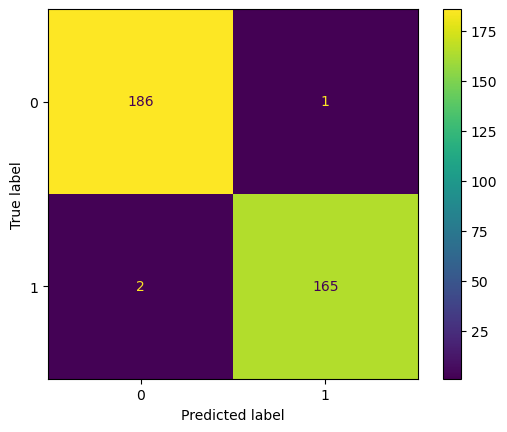

In [21]:
import matplotlib.pyplot as plt
cm_display.plot()
plt.show()

## Visualising The Tree

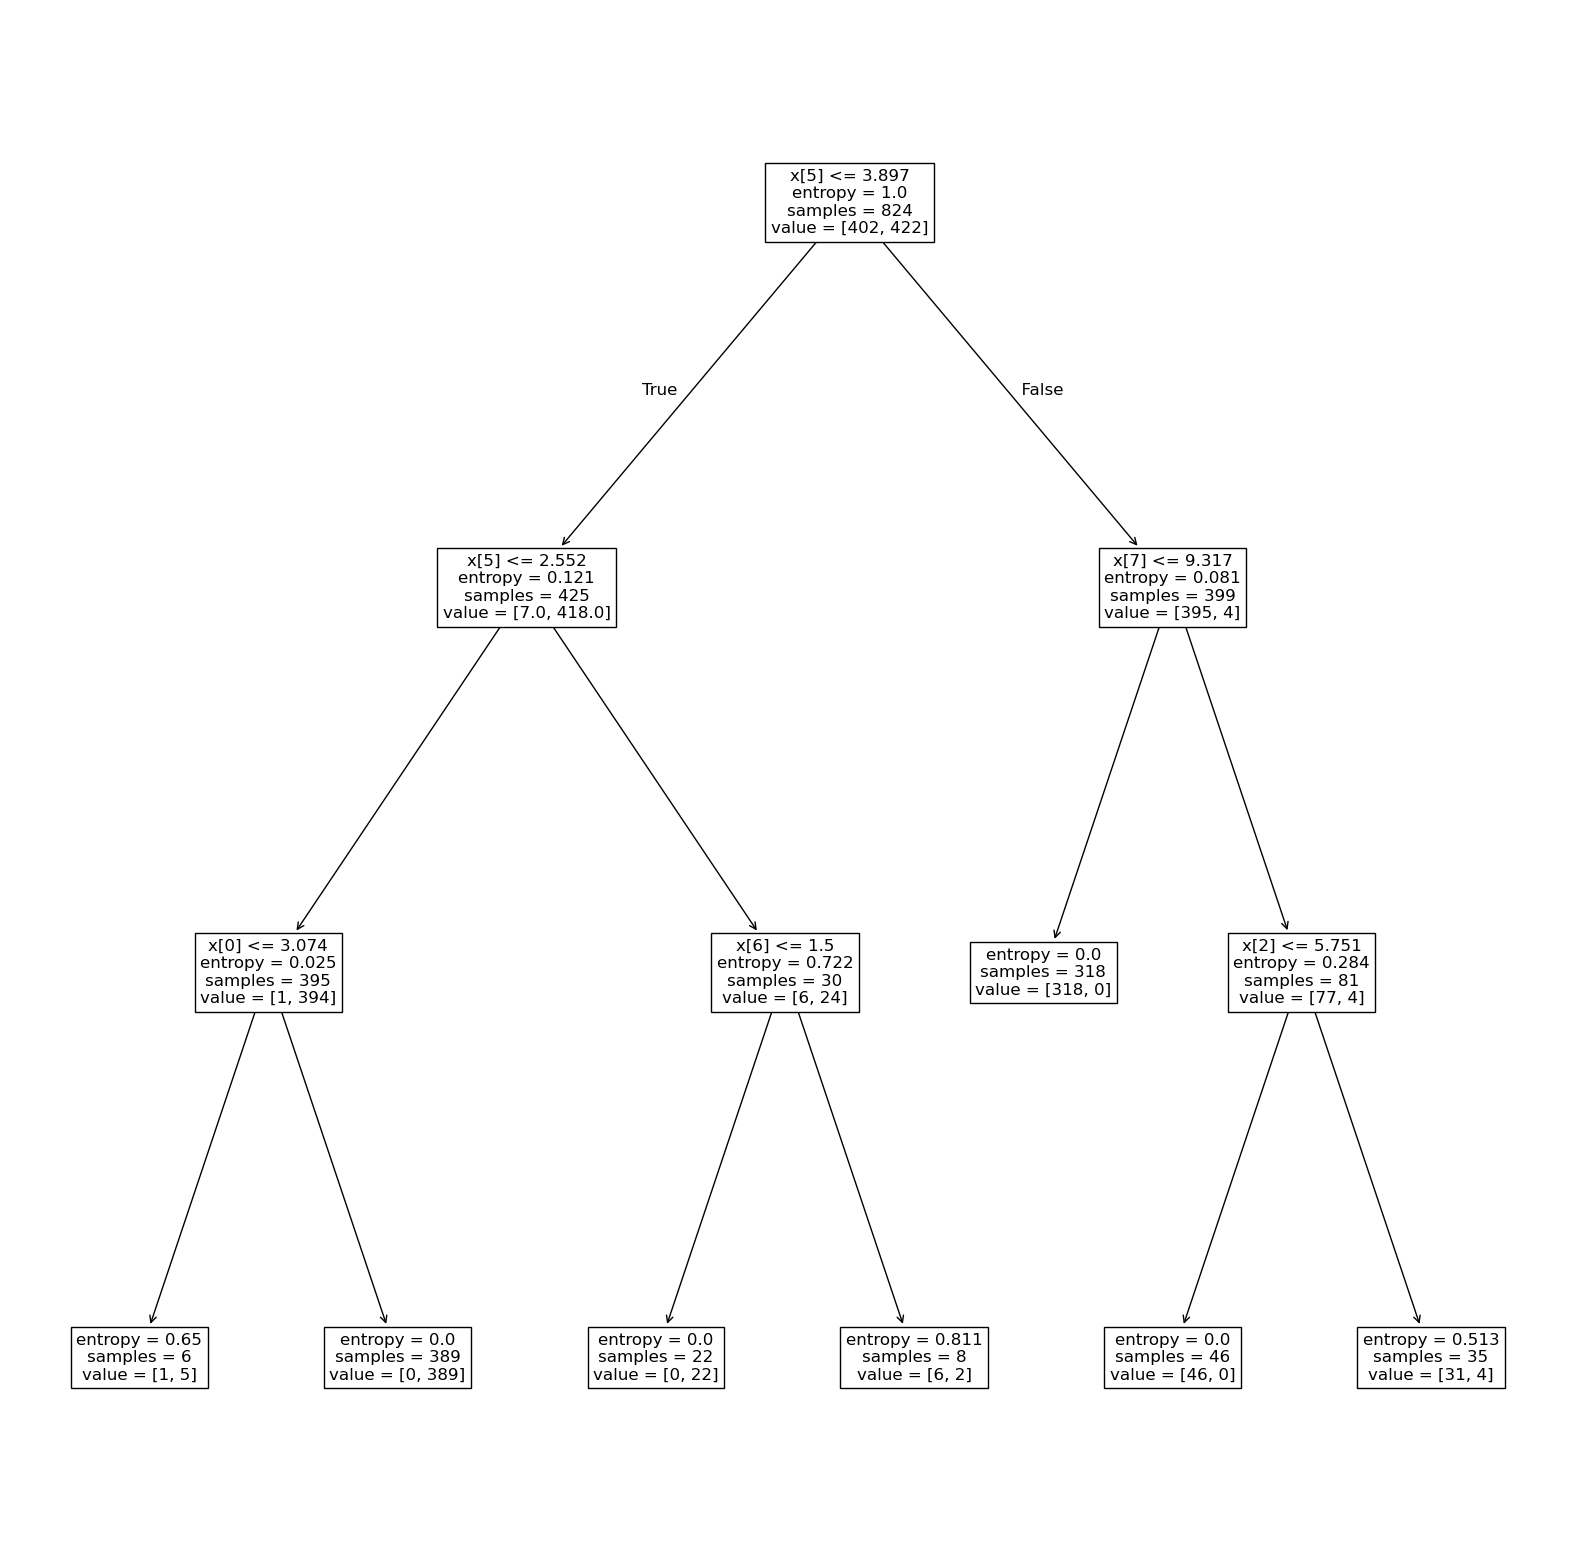

In [22]:
from sklearn import tree
plots_fol = "Plots"

plt.figure(figsize=(20,20))
tree.plot_tree(model, fontsize=12)
plt.savefig(f"{plots_fol}/decision_tree.jpg")

Mainly uses 1 feature to predict whether a transient exists with the feature being: 'deep_sep_arcsec'. Sometimes uses 'deep_num', 'beam_sep_deg', 'deep_peak_flux'.

## Cross Validation of The Model

In [23]:
from sklearn.model_selection import KFold, cross_val_score

In [24]:
k_folds = KFold(n_splits = 10)

# Obtain the cross validation scores of the decision tree classifier
scores = cross_val_score(model, X_train, y_train, cv = k_folds)
print("Cross Validation Scores: ", scores)

Cross Validation Scores:  [1.         1.         1.         0.98795181 1.         1.
 1.         0.96341463 0.96341463 0.98780488]


## Further Exploration of Wrongly Classified Candidates

In [25]:
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [26]:
sample_ids = X_test[y_test != y_pred].index

In [27]:
sample_ids

Index([66, 275, 297], dtype='int64')

In [28]:
y_test[sample_ids]

66     0
275    1
297    1
Name: PSR_Label, dtype: int64

In [29]:
def get_decision_path(sample_id):
    """
    Obtain the decision tree path. This function displays how input values
    travel through the decision tree's branches and conditions.

    This code was adapted from the sci-kit learn decision path documentation.
    Full reference is: scikit-learn, Decision Path, retrieved 28/11/2024 from, 
    https://scikit-learn.org/1.5/auto_examples/tree/plot_unveil_tree_structure.html

    Parameters
    ----------
    sample_id : int64
        Indices of a particular row of data or source candidate
        in the a particular dataframe.
    """
    # Obtained from sci-kit learn decision path documentation
    node_indicator = model.decision_path(X_test)
    leaf_id = model.apply(X_test)
    feature = model.tree_.feature
    threshold = model.tree_.threshold
    
    # obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
    node_index = node_indicator.indices[
        node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
    ]
    
    print("Rules used to predict sample {id}:\n".format(id=sample_id))
    for node_id in node_index:
        # continue to the next node if it is a leaf node
        if leaf_id[sample_id] == node_id:
            continue
    
        # check if value of the split feature for sample 0 is below threshold
        if X_test.loc[sample_id,feature_cols[feature[node_id]]] <= threshold[node_id]:
            threshold_sign = "<="
        else:
            threshold_sign = ">"
    
        print(
            "decision node {node} : (X_test[{sample}, {feature}] = {value} "
            "{inequality} {threshold})".format(
                node=node_id,
                sample=sample_id,
                feature=feature_cols[feature[node_id]],
                value=X_test.loc[sample_id,feature_cols[feature[node_id]]],
                inequality=threshold_sign,
                threshold=threshold[node_id],
            )
        )

In [30]:
# label the decision path more clearly
for sample_id in sample_ids:
    get_decision_path(sample_id)

Rules used to predict sample 66:

decision node 0 : (X_test[66, deep_sep_arcsec] = 1.7402883084134206 <= 3.896984100341797)
decision node 1 : (X_test[66, deep_sep_arcsec] = 1.7402883084134206 <= 2.5522347688674927)
decision node 2 : (X_test[66, chi_square] = 7.774417877197266 > 3.074222207069397)
Rules used to predict sample 275:

decision node 0 : (X_test[275, deep_sep_arcsec] = 241.13297838957016 > 3.896984100341797)
decision node 8 : (X_test[275, bright_sep_arcmin] = 6.717888320920349 <= 9.316909790039062)
Rules used to predict sample 297:

decision node 0 : (X_test[297, deep_sep_arcsec] = 130.86330608115 > 3.896984100341797)
decision node 8 : (X_test[297, bright_sep_arcmin] = 15.185220739964963 > 9.316909790039062)
decision node 10 : (X_test[297, peak_map] = 7.612082481384277 > 5.750894069671631)


# Testing on EMU Data

In [31]:
# Folder with all the EMU SB data
EMU_data_fol = "EMU_data"

In [32]:
test1_data = process_data(f"{EMU_data_fol}/SB50009.csv", feature_cols)

In [33]:
test_pred1 = model.predict(test1_data[feature_cols])

In [34]:
test2_data = process_data(f"{EMU_data_fol}/SB51428.csv", feature_cols)

In [35]:
test_pred2 = model.predict(test2_data[feature_cols])

In [36]:
print(test_pred1.sum())
print(test_pred2.sum())

12
21


In [37]:
test1_data.head()

,source_id,name,ra_str,dec_str,ra,dec,chi_square,chi_square_log_sigma,chi_square_sigma,peak_map,...,deep_ra_deg,deep_dec_deg,deep_peak_flux,deep_int_flux,priority,lightcurve,deepcutout,slices,beam,sbid
0,0,J163254.83-435657.54,16:32:54.83,-43:56:57.54,248.228458,-43.949316,7.314488,80.125671,1000000.000000,5.794533,...,248.581535,-43.881432,0.000368,0.000472,mid,ada.physics.usyd.edu.au:5203/SB50009/candidate...,ada.physics.usyd.edu.au:5203/SB50009/candidate...,ada.physics.usyd.edu.au:5203/SB50009/candidate...,beam00,50009
1,1,J163934.98-442638.10,16:39:34.98,-44:26:38.10,249.895771,-44.443917,1.804762,23.818495,27.835219,5.352377,...,249.963272,-44.363099,0.000365,0.000389,mid,ada.physics.usyd.edu.au:5203/SB50009/candidate...,ada.physics.usyd.edu.au:5203/SB50009/candidate...,ada.physics.usyd.edu.au:5203/SB50009/candidate...,beam00,50009
2,2,J164002.25-434415.51,16:40:02.25,-43:44:15.51,250.009367,-43.737642,1.296079,10.496992,11.528306,4.002834,...,250.006779,-43.737832,0.045615,0.046434,low,ada.physics.usyd.edu.au:5203/SB50009/candidate...,ada.physics.usyd.edu.au:5203/SB50009/candidate...,ada.physics.usyd.edu.au:5203/SB50009/candidate...,beam00,50009
3,3,J163403.73-430747.87,16:34:03.73,-43:07:47.87,248.515545,-43.129964,1.224004,8.194845,8.898140,3.996140,...,248.574590,-43.107840,0.001573,0.001312,mid,ada.physics.usyd.edu.au:5203/SB50009/candidate...,ada.physics.usyd.edu.au:5203/SB50009/candidate...,ada.physics.usyd.edu.au:5203/SB50009/candidate...,beam00,50009
4,4,J163714.67-442314.28,16:37:14.67,-44:23:14.28,249.311119,-44.387299,1.212237,7.806165,8.459185,3.462798,...,249.364394,-44.327250,0.000438,0.000744,mid,ada.physics.usyd.edu.au:5203/SB50009/candidate...,ada.physics.usyd.edu.au:5203/SB50009/candidate...,ada.physics.usyd.edu.au:5203/SB50009/candidate...,beam00,50009


### Looking at SB50009 Candidates

In [38]:
# Candidates for SB50009
def obtain_candidates(observation_id, test_data, test_pred, data_fol="EMU_data"):
    """
    Obtains the name and features for possible transient candidates.
    This function appends the indices of candidates to a file and
    each time this entire script is run and a new decision tree classifier
    is created, this function will append the new candidate indices predicted
    by the new classifier into the same file.

    The more a candidate appears after each subsequent run of the entire script,
    the more likely that it is a candidate.

    Parameters
    ----------
    observation_id : str
        Name or SBID of the sources

    test_data : pandas dataframe
        A dataframe containing the test data.

    test_pred : numpy array
        The test predictions of the decision tree.

    data_fol : str, default "EMU_data"
        The filepath to the folder with the transient candidate csvs.

    Returns
    -------
    cand_names : pandas dataframe
        Dataframe containing the indices and names of the transients that appear the most after each run of the script.

    cand_df : pandas dataframe
        Dataframe containing the indices, names and frequencies of all detected transients by every decision tree classifier that has been created
        using this script.
    """
    rel_data = pd.read_csv(f"{data_fol}/{observation_id}.csv")
    cand_idx = test_data[test_pred == 1].index
    
    # Append candidate indices to file
    with open(f"{data_fol}/{observation_id}_cand.txt", "a") as fobj:
        cand_idx_str = ', '.join(map(str,cand_idx))
        fobj.write(","+cand_idx_str)
    
    # Open file of candidate indices
    with open(f"{data_fol}/{observation_id}_cand.txt", "r") as fobj:
        cand_list = fobj.read()
    cand_arr = np.asarray(list(map(int,cand_list.split(",")[1:])))

    # Obtain the candidate names
    unique, frequency = np.unique(cand_arr, return_counts = True)
    cand_df = pd.DataFrame(list(zip(unique,list( rel_data.loc[unique, "name"]), frequency)), columns =["Index","Name", "Frequency"])
    cand_df = cand_df.sort_values("Frequency", ascending=False)
    cand_names = cand_df[cand_df["Frequency"] == max(cand_df["Frequency"])][["Index","Name"]].reset_index(drop=True)
    # Save the candidate names to a csv file
    cand_names.to_csv(f"{data_fol}/{observation_id}_Candidate_Names.csv", index=False)

    return cand_names, cand_df

In [39]:
cand_names59, cand_df59 = obtain_candidates("SB50009", test1_data, test_pred1)

In [40]:
cand_df59[cand_df59["Frequency"] == max(cand_df59["Frequency"])]

,Index,Name,Frequency
110,114,J165148.66-424610.59,35
32,34,J164920.45-434921.44,35
30,32,J164622.62-440541.28,35
179,183,J165148.68-424610.56,35
52,54,J164920.45-434921.44,35


In [41]:
cand_names59

,Index,Name
0,114,J165148.66-424610.59
1,34,J164920.45-434921.44
2,32,J164622.62-440541.28
3,183,J165148.68-424610.56
4,54,J164920.45-434921.44


Most of the recurring candidates for both sources have been confirmed to be real radio sources or pulsars. To start the frequency of the candidate dataframe back at 0, the contents in the file with "cand.txt" can be erased.

### Looking at SB51428 Candidates

In [42]:
cand_names58, cand_df58 = obtain_candidates("SB51428", test2_data, test_pred2)

In [43]:

cand_df58[cand_df58["Frequency"] == max(cand_df58["Frequency"])]

,Index,Name,Frequency
135,139,J094215.59-555254.17,35
208,213,J094215.42-555252.97,35
223,228,J100137.91-550708.01,35
233,239,J100137.94-550707.39,35
197,202,J094215.60-555253.83,35
300,307,J100137.90-550706.27,35
126,130,J094215.34-555254.47,35


In [44]:
cand_names58

,Index,Name
0,139,J094215.59-555254.17
1,213,J094215.42-555252.97
2,228,J100137.91-550708.01
3,239,J100137.94-550707.39
4,202,J094215.60-555253.83
5,307,J100137.90-550706.27
6,130,J094215.34-555254.47


In [45]:
SB58 = pd.read_csv(f"{EMU_data_fol}/SB51428.csv")

In [46]:
SB58.head()

,source_id,name,ra_str,dec_str,ra,dec,chi_square,chi_square_log_sigma,chi_square_sigma,peak_map,...,deep_ra_deg,deep_dec_deg,deep_peak_flux,deep_int_flux,priority,lightcurve,deepcutout,slices,beam,sbid
0,0,J093600.03-564500.11,09:36:00.03,-56:45:00.11,144.000134,-56.750031,3.253185,32.335190,inf,11.506310,...,143.998797,-56.749124,0.009961,0.006721,low,ada.physics.usyd.edu.au:5203/SB51428/candidate...,ada.physics.usyd.edu.au:5203/SB51428/candidate...,ada.physics.usyd.edu.au:5203/SB51428/candidate...,beam00,51428
1,1,J093434.96-582059.77,09:34:34.96,-58:20:59.77,143.645676,-58.349937,1.640034,13.610464,22.921040,4.713249,...,143.797481,-58.098571,0.000257,0.000218,mid,ada.physics.usyd.edu.au:5203/SB51428/candidate...,ada.physics.usyd.edu.au:5203/SB51428/candidate...,ada.physics.usyd.edu.au:5203/SB51428/candidate...,beam00,51428
2,1,J093436.86-582109.82,09:34:36.86,-58:21:09.82,143.653599,-58.352729,1.255492,6.305862,10.059348,9.101655,...,143.797481,-58.098571,0.000257,0.000218,high,ada.physics.usyd.edu.au:5203/SB51428/candidate...,ada.physics.usyd.edu.au:5203/SB51428/candidate...,ada.physics.usyd.edu.au:5203/SB51428/candidate...,beam00,51428
3,2,J093300.25-565129.68,09:33:00.25,-56:51:29.68,143.251047,-56.858245,1.132850,3.495680,5.421966,7.830315,...,143.246861,-56.856244,0.056653,0.066870,low,ada.physics.usyd.edu.au:5203/SB51428/candidate...,ada.physics.usyd.edu.au:5203/SB51428/candidate...,ada.physics.usyd.edu.au:5203/SB51428/candidate...,beam00,51428
4,3,J093346.08-580102.79,09:33:46.08,-58:01:02.79,143.441984,-58.017442,1.077550,2.127483,3.222357,6.877165,...,143.409544,-57.990823,0.000295,0.000261,high,ada.physics.usyd.edu.au:5203/SB51428/candidate...,ada.physics.usyd.edu.au:5203/SB51428/candidate...,ada.physics.usyd.edu.au:5203/SB51428/candidate...,beam00,51428


# Visualising The Results

In [47]:
def plot_all_against(balanced_t_data, features, x_feature = "deep_sep_arcsec", fol = "Plots", figsize = (8,32)):

    """
    Plot each feature against a particular feature such as "deep_sep_arcsec".
    The plots will be on a log-log axis with the colour of the labels being
    determined by the labels of the candidates.

    The code was adapted from JohanC's response to a stackoverflow question: 
    Creating Subplots inside a loop, generating Seaborn scatterplots (19/02/2024), 
    retrieved on 03/12/2024 from, 
    https://stackoverflow.com/questions/78021854/creating-subplots-inside-a-loop-generating-seaborn-scatterplots

    Parameters
    ----------
    balanced_t_data : pandas dataframe
        Dataframe containing data balanced by the number of each label.

    featuers : list
        The y axis features which you wish to plot against the x_feature.

    x_feature : str
        A selected feature for the x axis that stays the same in every plot.

    fol : str, default "Plots"
        The folder to store the plots.

    figsize : tuple, default (8,32)
        The figure size of the plots
    """
    x_final = balanced_t_data[x_feature]
    fig, axs = plt.subplots(nrows=len(features), figsize=(8, 32))
    for ax, f in zip(axs.flat, features):
        sns.scatterplot(x=x_final, legend=f==features[0],
                        y=balanced_t_data[f], hue=balanced_t_data["PSR_Label"], ax=ax)
        ax.set_title(f"{f} vs. {x_feature}")
        if f==features[0]: # create a legend only for the first plot
            sns.move_legend(ax, loc='upper left', bbox_to_anchor=(1.05, 1.02))
        ax.set_xscale("log")
        ax.set_yscale("log")
    plt.tight_layout()
    plt.show()
    fig.savefig(f"{fol}/Plot_of_Important_Features.png")

In [48]:
feature_cols

['chi_square',
 'chi_square_sigma',
 'peak_map',
 'peak_map_sigma',
 'md_deep',
 'deep_sep_arcsec',
 'deep_num',
 'bright_sep_arcmin',
 'beam_sep_deg',
 'deep_peak_flux',
 'deep_int_flux',
 'std_map']

In [49]:
# Plot other features against deep_sep_arcsec which was determined to be the most important feature
most_acc_features = feature_cols
x_feature = "deep_sep_arcsec"
most_acc_features = [f for f in feature_cols if f != x_feature]

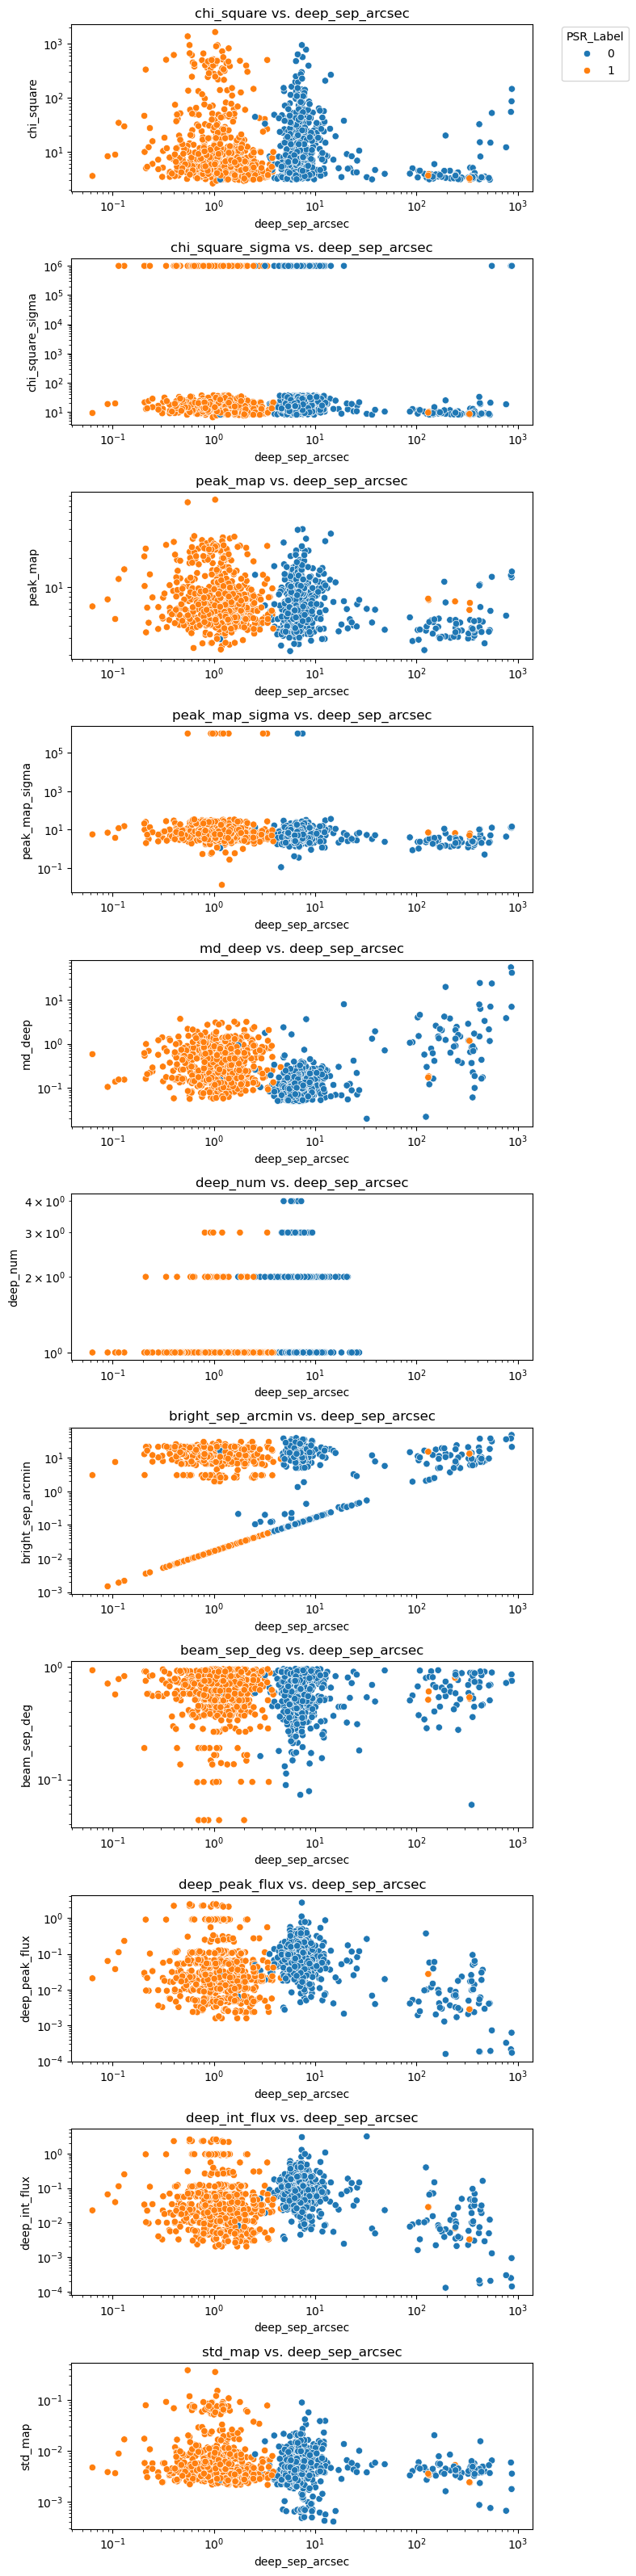

In [50]:
plot_all_against(balanced_t_data, most_acc_features, x_feature)

In most of the plots there are __three distinct outliers__ that are confirmed transients which have a much larger "deep_sep_arcsec" than the other candidates.

### Investigating The Outliers

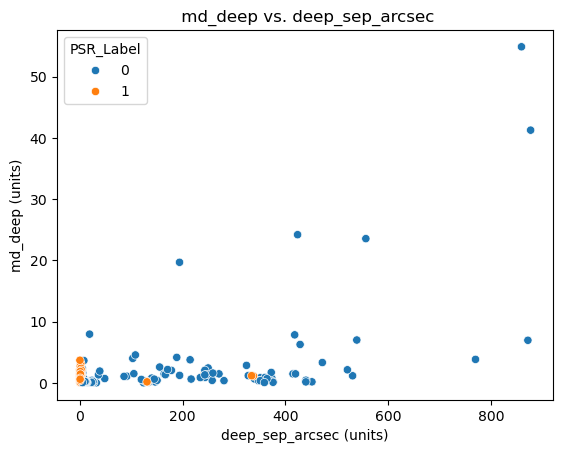

In [51]:
# Plot a feature against deep_sep_arcsec and note the outliers

x_ax = "deep_sep_arcsec"
y_ax = "md_deep"

sns.scatterplot(x=balanced_t_data[x_ax], y=balanced_t_data[y_ax], hue=balanced_t_data["PSR_Label"]) # plot all important features against deep_sep_arcsec

ax = plt.gca()

plt.title(f" {y_ax} vs. {x_ax}")
plt.xlabel(f"{x_ax} (units)")
plt.ylabel(f"{y_ax} (units)")
plt.show()

In [52]:
new_data = pd.read_csv("Transient_Data_Selected_Features.csv")

In [53]:
# Look for the information around the group of outliers with a label of 1.

y_ax_min = 1
y_ax_max = 1.4
x_ax_min = 200
x_ax_max = 400
new_data[(new_data[x_ax] > x_ax_min) & (new_data[x_ax] < x_ax_max) & (new_data[y_ax] > y_ax_min) & (new_data[y_ax] < y_ax_max)]

,chi_square,chi_square_sigma,peak_map,peak_map_sigma,std_map,md_deep,deep_sep_arcsec,deep_num,bright_sep_arcmin,beam_sep_deg,deep_peak_flux,deep_int_flux,PSR_Label
14,5.340294,13.508775,3.842686,2.635667,0.011819,1.250849,327.599942,0,5.459999,0.663921,0.015104,0.132303,0
101,3.855998,10.243965,4.715344,3.761479,0.006342,1.000108,254.745576,0,16.499943,0.778649,0.012088,0.018627,0
2703,3.096177,8.155591,2.822160,0.975055,0.003336,1.080770,297.024755,0,10.508061,0.852509,0.006689,0.006514,0
2734,4.793410,12.441148,4.184765,3.090493,0.007025,1.079989,307.268949,0,8.415781,0.691854,0.010825,0.011561,0
2799,3.201503,8.451473,2.877281,1.086971,0.004415,1.381888,322.992651,0,15.683803,0.718457,0.005533,0.006181,0
2828,3.820998,10.082917,1.975866,NaN,0.006303,1.329038,331.659792,0,6.830054,0.475667,0.006034,0.004878,0
2856,3.417934,9.106974,2.990090,1.294877,0.005824,1.384758,259.094614,0,10.983549,0.410549,0.005032,0.005515,0
2904,5.041740,12.979735,4.882500,3.965233,0.005828,1.056013,207.681695,0,8.997117,0.908580,0.013289,0.021339,0
2926,4.256892,11.137660,3.783735,2.553639,0.006068,1.366333,383.754621,0,6.406698,0.579701,0.006351,0.008607,0
2932,3.200347,8.448258,3.416488,2.016222,0.004860,1.260070,257.382908,0,8.853952,0.723173,0.006730,0.009138,0


The above features correspond to candidates which have a similar "md_deep" and "deep_sep_arcsec" to the three aforementioned outliers.